# Noise reduction + wavelet transform

## Overall process

From each segments:

* Noise reduction using ICA algorithm (fastICA from sklearn)
* Wavelet transform
* Features extraction (mean absolute value, average power, standard deviation, variance, mean, skewness, and Shannon entropy)
* Classification (KNN, SVM, ...)

## Imports

In [1]:
import pywt
from os import listdir, path, walk, makedirs
import random
import numpy as np
from pyentrp import entropy
from scipy.stats import median_absolute_deviation
from sklearn.preprocessing import RobustScaler
import pandas as pd
import scipy.io
from scipy.signal import spectrogram
from scipy.signal import resample
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, make_scorer
import xgboost as xgb

In [3]:
import pickle

## Load test data

## ICA noise reduction

In [4]:
from sklearn.decomposition import FastICA

## Feature extraction

In [5]:
# mean absolute value, average power, standard deviation, variance, mean, skewness, and Shannon entropy

In [6]:
def flatten_list(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [7]:
def mean_absolute_value(array):
    absolute_values = []
    for i in range(len(array)):
        absolute_values.append(abs(array[i]))
    mean_absolute_value = np.asarray(absolute_values).sum()*(1/len(array))
    #print(mean_absolute_value)
    return mean_absolute_value

In [8]:
def average_power(array):
    average_power_values = []
    for i in range(len(array)):
        average_power_values.append(abs(array[i])**2)
    average_power_value = np.asarray(average_power_values).sum()*(1/len(array))
    #print(average_power_value)
    return average_power_value

In [9]:
def shan(d1):
    sh1=[]
    d1=np.rint(d1)
    for i in range(d1.shape[0]):
        X=d1[i]
        sh1.append(entropy.shannon_entropy(X))
    return(sh1)

In [10]:
def feature_extraction(decomposed_signals):
    mav = []
    avp = []
    std = []
    var = []
    mean = []
    for coeff in decomposed_signals:
        mav_electrode = []
        avp_electrode = []
        std_electrode = []
        var_electrode = []
        mean_electrode = []
        for electrode in coeff:
            mav_electrode.append(mean_absolute_value(electrode))
            avp_electrode.append(average_power(electrode))
            std_electrode.append(np.std(electrode))
            var_electrode.append(np.var(electrode))
            mean_electrode.append(np.mean(electrode))
        mav.append(mav_electrode)
        avp.append(avp_electrode)
        std.append(std_electrode)
        var.append(var_electrode)
        mean.append(mean_electrode)
    mav = flatten_list(mav)
    avp = flatten_list(avp)
    std = flatten_list(std)
    var = flatten_list(var)
    mean = flatten_list(mean)
    shan_ent = []
    for i in range(len(decomposed_signals)):
        shan_ent.append(shan(coeffs[i]))
    shan_ent = flatten_list(shan_ent)
    data = np.vstack((np.array(mav), np.array(avp), 
                     np.array(std), np.array(var), np.array(mean), np.array(shan_ent)))
    #data = pd.DataFrame(data)
    features = data.T
    #features.columns = ['mean_abs_value', 'average_power', 'std', 'var', 'mean', 'shannon_entropy']

    return features

In [11]:
import re 
def regex(filename):
    return re.findall('(?<=\_)\d+(?=\W)', filename)


In [12]:
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
    return l

In [13]:
with open('features', 'rb') as f:
    features = pickle.load(f)
with open('target', 'rb') as f:
    target = pickle.load(f)

In [14]:
# flatten the ndarray
flatten_data = np.array(features).reshape(len(features),-1)
del features
target = np.array(target)

filelist = []
for root, dirs, files in walk('Preictal_only_mixed/'):
    for f in files:
        if 'preictal' in f: 
            filelist.append(path.join(root, f))
filelist = sort_nicely(filelist)


class_number = 1
if not path.exists(path.join(f'split_csv/{class_number}')):
            makedirs(path.join(f'split_csv/{class_number}'))

segment_size = 2000

class_number = 1
filenumber = 1

flag = 0

for i in filelist:
    
    temp = pd.read_csv(i)        
    
    for j in range(temp.shape[0]):   #iterate through all sensors
        idx = 0
        while idx + segment_size <= len(temp.iloc[0]):
            segment = temp.iloc[j][idx:idx + segment_size]
            segment.to_csv(f'split_csv/{class_number}/{filenumber}.csv')
            
            filenumber += 1
            idx = idx + segment_size
            
    if flag == 1:
        class_number += 1
        #flag = 0
        if not path.exists(path.join(f'split_csv/{class_number}')):
            makedirs(path.join(f'split_csv/{class_number}'))
    
    if (int(regex(i)[0]) % 3 == 0 and flag == 0):
        flag = 1
    else:
        flag = 0


## Feature extraction for each segment

filelist = []
for root, dirs, files in walk('split_csv/'):
    for f in files:
            filelist.append(path.join(root, f))
#filelist = sort_nicely(filelist)

# Pipeline: ICA -> Wavelet -> Feature extraction as array -> build target vector
ica_transformer = FastICA(n_components= 10,max_iter= 3000000, random_state=0, tol=0.1)
wavelet = pywt.Wavelet('db4')
features = []
target = []

#for root, dirs, files in walk('split_csv/'):
for f in filelist:
        print(f)
        segment = pd.read_csv(f)
        #segment_scaled = robust_scaler.fit_transform(segment)
        segment_transformed = ica_transformer.fit_transform(segment)
        coeffs = pywt.wavedec(segment_transformed, wavelet, level = 1)
        segment_features = feature_extraction(coeffs)
        np.asarray(features.append(segment_features))
        print('class:', f.split('/')[1])
        target.append(f.split('/')[1])

print(len(features), (features[0].shape), target, len(target))

with open('features', 'wb') as f:
    pickle.dump(features, f)
with open('target', 'wb') as f:
    pickle.dump(target, f)

## Logistic regression

In [15]:
X_train, X_test, y_train, y_test = train_test_split(flatten_data, target, test_size=0.3, random_state=42)

In [16]:
scoring = {'Accuracy': make_scorer(accuracy_score), 
           'Precision': make_scorer(precision_score, average='weighted'),
          'Recall': make_scorer(recall_score, average='weighted'),
          'f1': make_scorer(f1_score, average='weighted')}

In [17]:

#from imblearn.over_sampling import SMOTE

log_reg = LogisticRegression(max_iter=1000)
#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X,y)


#X_resampled, y_resampled = sm.fit_resample(flatten_data, target)

cv_results = cross_validate(log_reg, flatten_data, target, cv=5, scoring=scoring)
cv_results

{'fit_time': array([208.48766541, 187.26031113, 196.85474753, 191.84046793,
        201.70064521]),
 'score_time': array([0.08307719, 0.06352925, 0.06365514, 0.06551313, 0.06398654]),
 'test_Accuracy': array([0.69848053, 0.69563153, 0.67806268, 0.69088319, 0.69705603]),
 'test_Precision': array([0.70077899, 0.69923902, 0.68803292, 0.69714983, 0.70350443]),
 'test_Recall': array([0.69848053, 0.69563153, 0.67806268, 0.69088319, 0.69705603]),
 'test_f1': array([0.69916926, 0.69702222, 0.68103951, 0.693069  , 0.69940921])}

In [18]:
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [19]:
acc = round(cv_results['test_Accuracy'].mean()*100,1)
prec = round(cv_results['test_Precision'].mean()*100,1)
rec = round(cv_results['test_Recall'].mean()*100,1)
f1 = round(cv_results['test_f1'].mean()*100,1)

In [20]:
print(f'Logistic Regression Accuracy: {acc}%')
print(f'Logistic Regression Precision: {prec}%')
print(f'Logistic Regression Recall: {rec}%')
print(f'Logistic Regression f1: {f1}%')


Logistic Regression Accuracy: 69.2%
Logistic Regression Precision: 69.8%
Logistic Regression Recall: 69.2%
Logistic Regression f1: 69.4%


In [21]:
y_pred = log_reg.predict(X_test)

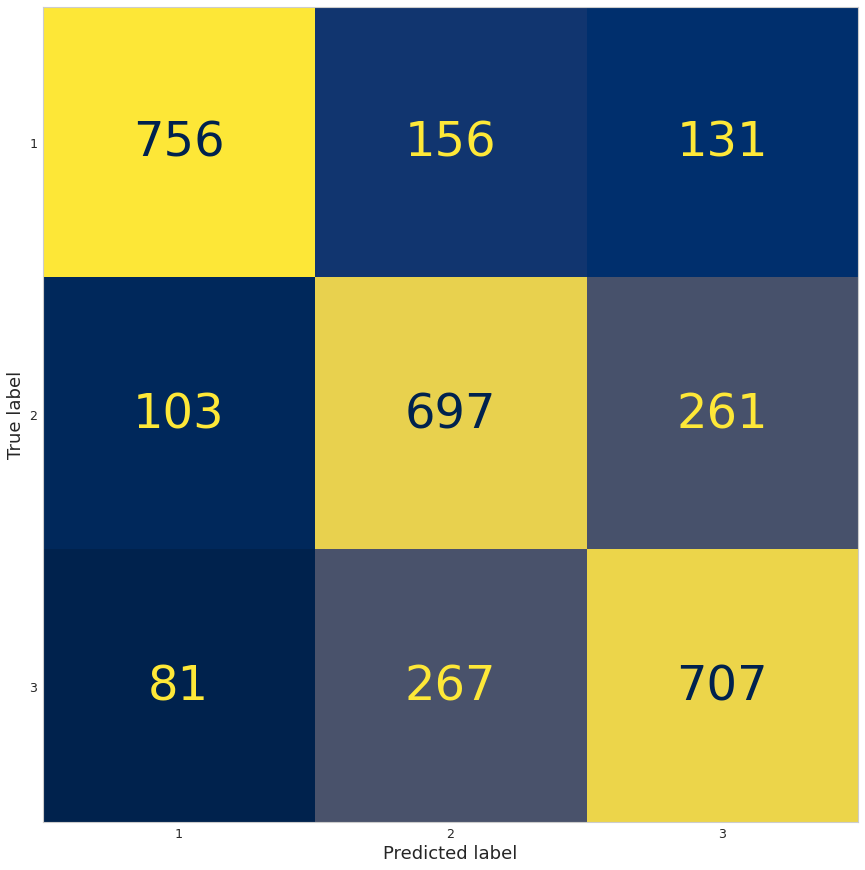

In [22]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.grid(False)
sns.set(font_scale=4.0)
label_font = {'size':'18'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

plot_confusion_matrix(log_reg, X_test, y_test, ax=ax, cmap='cividis', colorbar=False);

plt.savefig('confusion_matrix_log_reg.png', bbox_inches='tight')
plt.show()

In [23]:
with open('logistic_regression_model', 'wb') as f:
    pickle.dump(log_reg, f)

## Support Vector Machines

### Linear kernel

In [25]:
svc_linear = SVC(kernel='linear')
cv_results = cross_validate(svc_linear, flatten_data, target, cv=5, scoring=scoring, verbose=1, n_jobs=-1)
cv_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 36.1min finished


{'fit_time': array([1768.71709967, 1861.52088141, 1778.19291759, 1783.37690139,
        1644.80902481]),
 'score_time': array([362.55226445, 303.7440393 , 358.91612959, 353.54238057,
        385.92164993]),
 'test_Accuracy': array([0.71794872, 0.71794872, 0.69895537, 0.70797721, 0.70512821]),
 'test_Precision': array([0.7184823 , 0.72038214, 0.70676356, 0.71240623, 0.71119173]),
 'test_Recall': array([0.71794872, 0.71794872, 0.69895537, 0.70797721, 0.70512821]),
 'test_f1': array([0.71765304, 0.71886476, 0.70141971, 0.70962655, 0.707497  ])}

In [26]:
svc_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [27]:
acc = round(cv_results['test_Accuracy'].mean()*100,1)
prec = round(cv_results['test_Precision'].mean()*100,1)
rec = round(cv_results['test_Recall'].mean()*100,1)
f1 = round(cv_results['test_f1'].mean()*100,1)

In [28]:
print(f'SVM Linear Accuracy: {acc}%')
print(f'SVM Linear Precision: {prec}%')
print(f'SVM Linear Recall: {rec}%')
print(f'SVM Linear f1: {f1}%')

SVM Linear Accuracy: 71.0%
SVM Linear Precision: 71.4%
SVM Linear Recall: 71.0%
SVM Linear f1: 71.1%


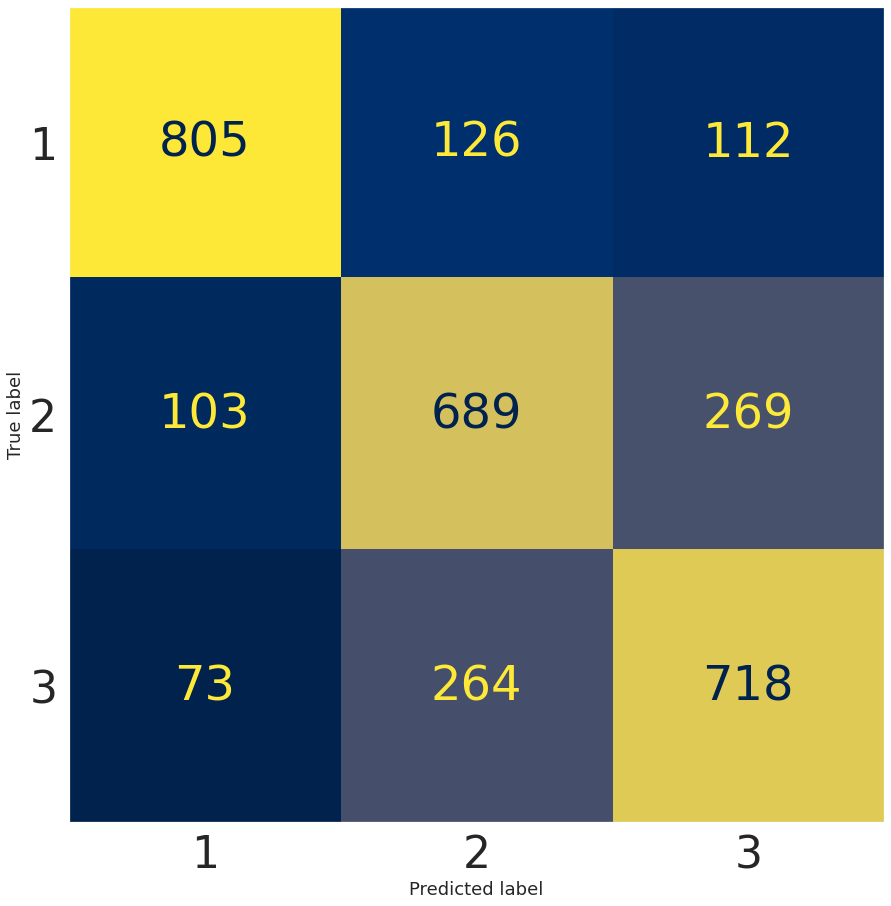

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.grid(False)
sns.set(font_scale=4.0)
label_font = {'size':'18'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

plot_confusion_matrix(svc_linear, X_test, y_test, ax=ax, cmap='cividis', colorbar=False);

plt.savefig('confusion_matrix_svm_linear.png', bbox_inches='tight')
plt.show()

In [30]:
with open('svc_linear_model', 'wb') as f:
    pickle.dump(svc_linear, f)

### Polynomial kernel

In [31]:
svc_poly = SVC(kernel='poly')
cv_results = cross_validate(svc_poly, flatten_data, target, cv=5, scoring=scoring, verbose=1, n_jobs=-1)
cv_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 33.7min finished


{'fit_time': array([1633.31370616, 1682.48533893, 1654.40717363, 1660.31376004,
        1599.08683681]),
 'score_time': array([374.88018203, 327.46004915, 331.14355731, 336.66542292,
        404.82267642]),
 'test_Accuracy': array([0.83903134, 0.84140551, 0.82193732, 0.83808167, 0.83950617]),
 'test_Precision': array([0.84032399, 0.84432464, 0.82756059, 0.8405253 , 0.84217011]),
 'test_Recall': array([0.83903134, 0.84140551, 0.82193732, 0.83808167, 0.83950617]),
 'test_f1': array([0.83957107, 0.84223619, 0.82406709, 0.83894256, 0.84061542])}

In [32]:
svc_poly.fit(X_train, y_train)

SVC(kernel='poly')

In [34]:
acc = round(cv_results['test_Accuracy'].mean()*100,1)
prec = round(cv_results['test_Precision'].mean()*100,1)
rec = round(cv_results['test_Recall'].mean()*100,1)
f1 = round(cv_results['test_f1'].mean()*100,1)

In [35]:
print(f'SVM Poly Accuracy: {acc}%')
print(f'SVM Poly Precision: {prec}%')
print(f'SVM Poly Recall: {rec}%')
print(f'SVM Poly f1: {f1}%')

SVM Poly Accuracy: 83.6%
SVM Poly Precision: 83.9%
SVM Poly Recall: 83.6%
SVM Poly f1: 83.7%


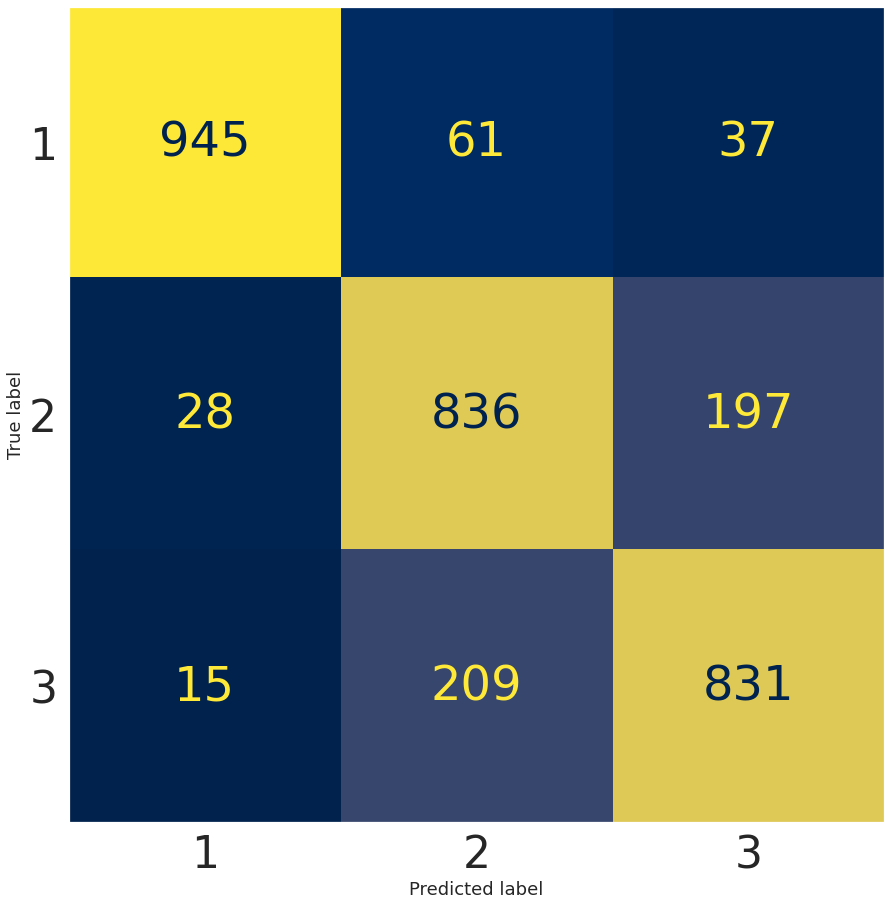

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.grid(False)
sns.set(font_scale=4.0)
label_font = {'size':'18'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

plot_confusion_matrix(svc_poly, X_test, y_test, ax=ax, cmap='cividis', colorbar=False);

plt.savefig('confusion_matrix_svm_poly.png', bbox_inches='tight')
plt.show()

In [37]:
with open('svc_polynomial_model', 'wb') as f:
    pickle.dump(svc_poly, f)

## KNeighbors Classifier

In [38]:
knn = KNeighborsClassifier(n_neighbors=3)

cv_results = cross_validate(knn, flatten_data, target, cv=5, scoring=scoring, verbose=1, n_jobs=-1)
cv_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.9s finished


{'fit_time': array([5.28891397, 5.36686635, 5.46610022, 4.90653896, 3.56037807]),
 'score_time': array([17.19126081, 18.04143715, 17.4381144 , 18.14567113, 17.48079228]),
 'test_Accuracy': array([0.88888889, 0.89411206, 0.87179487, 0.87796771, 0.86989554]),
 'test_Precision': array([0.88804643, 0.89343264, 0.87108548, 0.87793646, 0.86860019]),
 'test_Recall': array([0.88888889, 0.89411206, 0.87179487, 0.87796771, 0.86989554]),
 'test_f1': array([0.88823675, 0.89368352, 0.8710328 , 0.87790331, 0.86901998])}

In [39]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [40]:
acc = round(cv_results['test_Accuracy'].mean()*100,1)
prec = round(cv_results['test_Precision'].mean()*100,1)
rec = round(cv_results['test_Recall'].mean()*100,1)
f1 = round(cv_results['test_f1'].mean()*100,1)

In [41]:
print(f'KNeighbors Accuracy: {acc}%')
print(f'KNeighbors Precision: {prec}%')
print(f'KNeighbors Recall: {rec}%')
print(f'KNeighbors f1: {f1}%')

KNeighbors Accuracy: 88.1%
KNeighbors Precision: 88.0%
KNeighbors Recall: 88.1%
KNeighbors f1: 88.0%


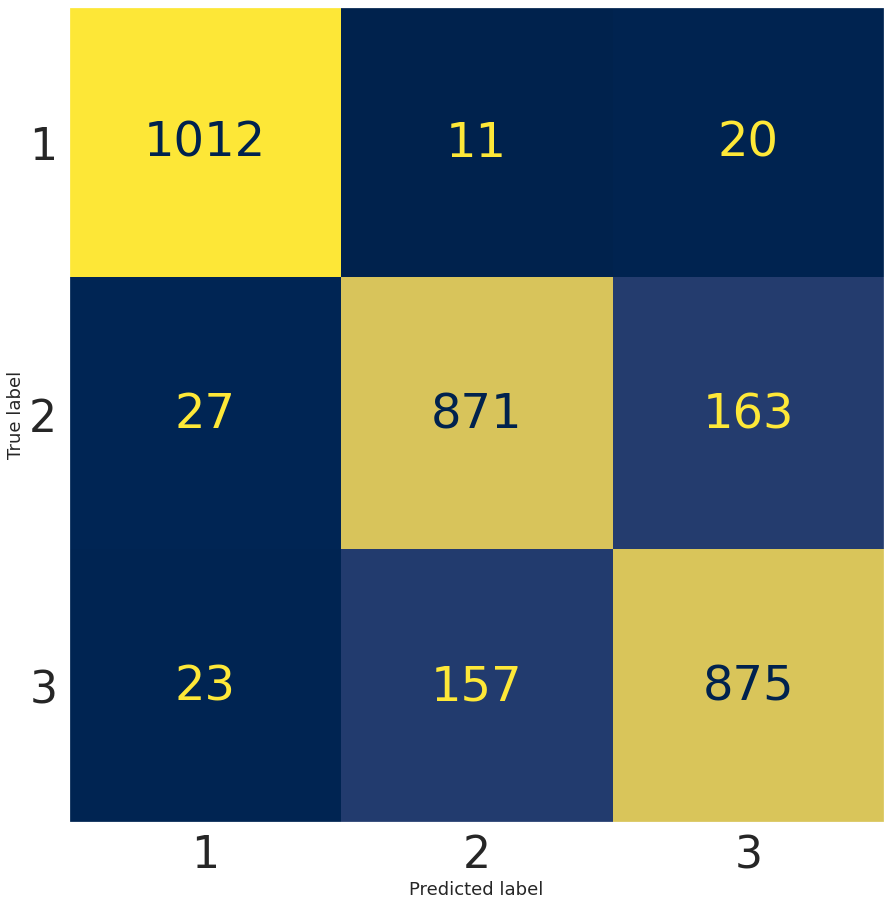

In [42]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.grid(False)
sns.set(font_scale=4.0)
label_font = {'size':'18'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

plot_confusion_matrix(knn, X_test, y_test, ax=ax, cmap='cividis', colorbar=False);

plt.savefig('confusion_matrix_kneighbors.png', bbox_inches='tight')
plt.show()

In [43]:
with open('kneighbors_model', 'wb') as f:
    pickle.dump(knn, f)

## Ensemble classifiers

In [44]:

random_forest = RandomForestClassifier(n_estimators=100)

cv_results = cross_validate(random_forest, flatten_data, target, cv=5, scoring=scoring, n_jobs=-1)
cv_results

{'fit_time': array([198.37487292, 149.56994748, 155.39573717, 154.00879383,
        160.36596918]),
 'score_time': array([0.24455786, 0.36934686, 0.23959947, 0.26171017, 0.22561216]),
 'test_Accuracy': array([0.76875594, 0.7640076 , 0.74643875, 0.75973409, 0.75308642]),
 'test_Precision': array([0.79466726, 0.78970086, 0.77573757, 0.78433511, 0.77554099]),
 'test_Recall': array([0.76875594, 0.7640076 , 0.74643875, 0.75973409, 0.75308642]),
 'test_f1': array([0.77361565, 0.76876379, 0.75233663, 0.76477471, 0.75864657])}

In [45]:
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
acc = round(cv_results['test_Accuracy'].mean()*100,1)
prec = round(cv_results['test_Precision'].mean()*100,1)
rec = round(cv_results['test_Recall'].mean()*100,1)
f1 = round(cv_results['test_f1'].mean()*100,1)

In [47]:
print(f'Random Forest Accuracy: {acc}%')
print(f'Random Forest Precision: {prec}%')
print(f'Random Forest Recall: {rec}%')
print(f'Random Forest f1: {f1}%')

Random Forest Accuracy: 75.8%
Random Forest Precision: 78.4%
Random Forest Recall: 75.8%
Random Forest f1: 76.4%


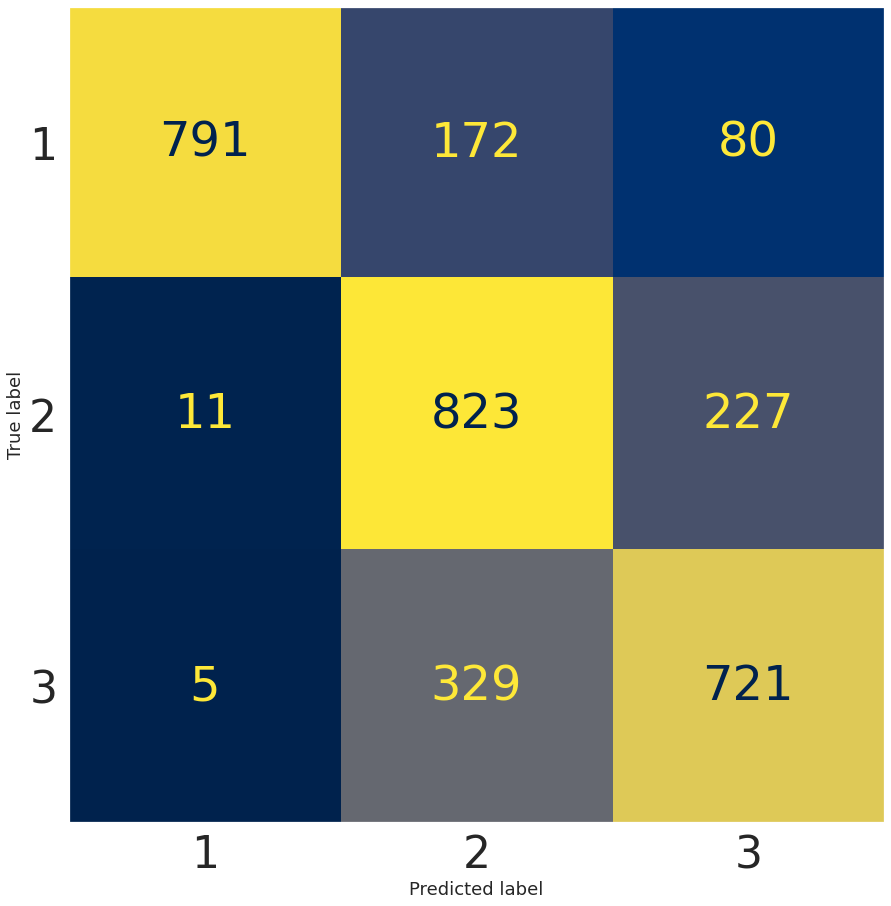

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.grid(False)
sns.set(font_scale=4.0)
label_font = {'size':'18'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

plot_confusion_matrix(random_forest, X_test, y_test, ax=ax, cmap='cividis', colorbar=False);

plt.savefig('confusion_matrix_random_forest.png', bbox_inches='tight')
plt.show()

In [49]:
with open('random_forest_model', 'wb') as f:
    pickle.dump(random_forest, f)

## XGBoost Classifier

In [50]:
gradient_boosting = xgb.XGBClassifier(objective="multi:softprob", booster='gbtree', base_score=0.33, n_estimators=2000, eta=0.05, silent='False', verbosity=3, tree_method='gpu_hist', gpu_id=0, n_jobs=-1)

In [52]:
gradient_boosting.fit(X_train,y_train)

[21:22:53] DEBUG: ../src/tree/updater_gpu_hist.cu:899: [GPU Hist]: Configure
[21:22:53] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:22:53] DEBUG: ../src/common/device_helpers.cu:38: Running nccl init on: 10.0
[21:22:54] ======== Monitor: SketchContainer ========
[21:22:54] MakeCuts: 0.014826s, 1 calls @ 14826us

[21:22:54] Prune: 0.012182s, 1 calls @ 12182us

[21:22:54] ScanInput: 0.136876s, 1 calls @ 136876us

[21:22:54] Unique: 0.011421s, 1 calls @ 11421us

[21:22:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:40

XGBClassifier(base_score=0.33, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, silent='False', subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=3)

In [53]:
y_pred = gradient_boosting.predict(X_test)

In [60]:
gradient_boosting.evals_result

AttributeError: 'XGBClassifier' object has no attribute 'evals_result_'

In [55]:
confusion_matrix(y_test, y_pred)

array([[930,  74,  39],
       [ 20, 851, 190],
       [  9, 232, 814]])

In [56]:
print(f'Gradient Boosting Accuracy: {round(accuracy_score(y_test,y_pred)*100,1)}')
print(f'Gradient Boosting Precision: {round(precision_score(y_test,y_pred, average="weighted")*100,1)}')
print(f'Gradient Boosting Recall: {round(recall_score(y_test,y_pred, average="weighted")*100,1)}')
print(f'Gradient Boosting f1: {round(f1_score(y_test,y_pred, average="weighted")*100,1)}')


Gradient Boosting Accuracy: 82.1
Gradient Boosting Precision: 82.8
Gradient Boosting Recall: 82.1
Gradient Boosting f1: 82.4


In [57]:
#no cross validation needed with XGBoost

#cv_results = cross_validate(gradient_boosting, flatten_data, target, cv=5, scoring=scoring, n_jobs=-1)
#cv_results

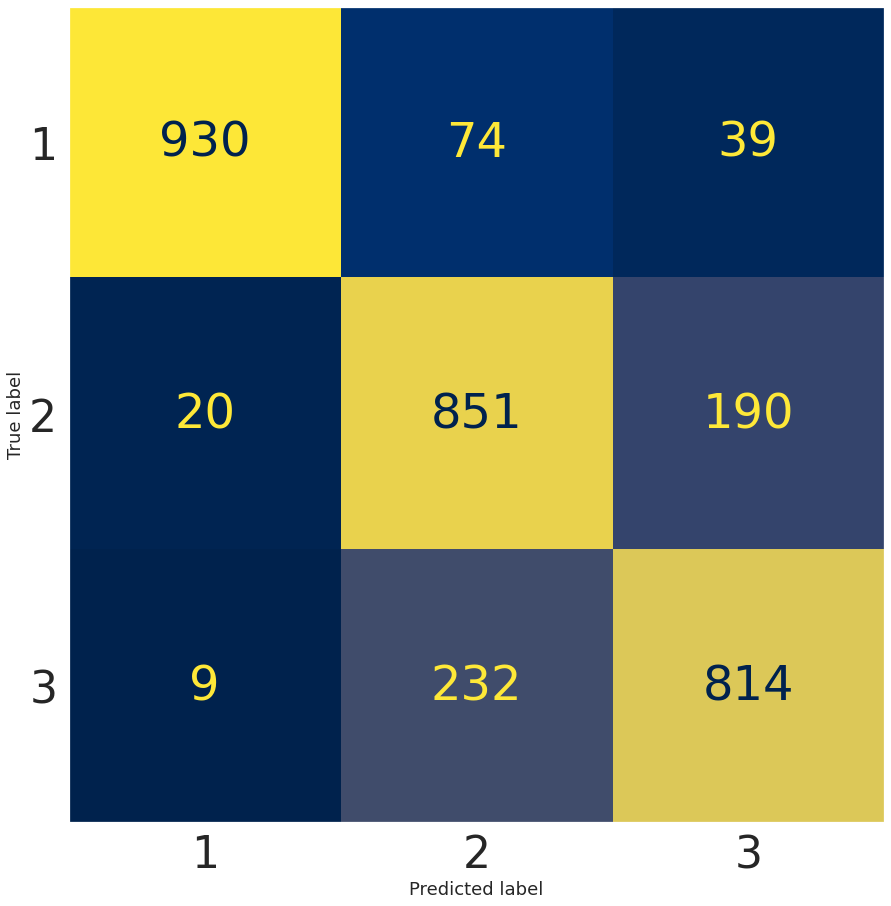

In [58]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.grid(False)
sns.set(font_scale=4.0)
label_font = {'size':'18'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

plot_confusion_matrix(gradient_boosting, X_test, y_test, ax=ax, cmap='cividis', colorbar=False);

plt.savefig('confusion_matrix_gradient_boosting.png', bbox_inches='tight')
plt.show()

In [59]:
with open('gradient_boosting_model', 'wb') as f:
    pickle.dump(gradient_boosting, f)